# load modules

In [4]:
import pandas as pd
import torch
import torch.nn as nn
import tqdm
import torch.nn.functional as F
import os
import numpy as np
import random
import re
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import math
import torchvision
from IPython.display import display, HTML
from IPython.display import display
display(HTML("<style>.container { width:70% !important; }</style>"))

from functions import *

# load test data

In [5]:
dataset = torch.load('data/dataset.pt')
dataset = dataset.permute(1, 0, 2, 3)

norm_dataset = torch.load("data/dataset_distlognorm_massnorm.pt")

fake_original = torch.load('data/fake_dataset.pt')

fake_data = torch.load("models/attempt1/generated_images.pt")

six_branches = torch.load('data/six_branch_norm.pt')
six_dataset = six_branches[:, :, :, :6]

fake_data.shape, six_dataset.shape, dataset.shape, fake_original.shape

(torch.Size([8161, 3, 29, 6]),
 torch.Size([8161, 3, 29, 6]),
 torch.Size([38348, 3, 29, 10]),
 torch.Size([38500, 3, 29, 10]))

# Analyze

## full original dataset

In [4]:
full_evaluation(dataset)

Analyzing generated merger tree dataset ...

			 CONSISTENCY CHECK



Percentage of consistant images = 71.98%



Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 98.55%
inconsistency due to distance not zero in main branch =  0.00%
inconsistency due to gap between branches =  6.08%
inconsistency due to zgap in branch 3.12%
inconsistency due to last descendant dont exist 0.00%

Number of images with two or more inconsistencies = 797, which is  7.42%
That corresponds to 2.08% of all images


Of all images, 27.62% have zero inconsistency
Of all images, 0.00% have distance main branch inconsistency
Of all images, 1.70% have gap between branches inconsistency
Of all images, 0.87% have gap within branch inconsistency
Of all images, 0.00% have last descendant inconsistency
			 VARIABLE CONSISTENY CHECK of consistent trees
-------------------------------------------------------------------------------------------------------
MASS:
------------------------------------------

## six branches original dataset

In [5]:
full_evaluation(six_dataset)

Analyzing generated merger tree dataset ...

			 CONSISTENCY CHECK



Percentage of consistant images = 75.22%



Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 97.58%
inconsistency due to distance not zero in main branch =  0.00%
inconsistency due to gap between branches =  3.51%
inconsistency due to zgap in branch 3.91%
inconsistency due to last descendant dont exist 0.00%

Number of images with two or more inconsistencies = 100, which is  4.95%
That corresponds to 1.23% of all images


Of all images, 24.18% have zero inconsistency
Of all images, 0.00% have distance main branch inconsistency
Of all images, 0.87% have gap between branches inconsistency
Of all images, 0.97% have gap within branch inconsistency
Of all images, 0.00% have last descendant inconsistency
			 VARIABLE CONSISTENY CHECK of consistent trees
-------------------------------------------------------------------------------------------------------
MASS:
------------------------------------------

## generated merger trees from robles et al. (2022)

In [6]:
full_evaluation(fake_original)

Analyzing generated merger tree dataset ...

			 CONSISTENCY CHECK


Percentage of consistant images = 0.0%

Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 100.00%
inconsistency due to distance not zero in main branch =  100.00%
inconsistency due to gap between branches =  68.55%
inconsistency due to zgap in branch 99.89%
inconsistency due to last descendant dont exist 50.81%

Number of images with two or more inconsistencies = 38500, which is  100.00%
That corresponds to 100.00% of all images


Of all images, 100.00% have zero inconsistency
Of all images, 100.00% have distance main branch inconsistency
Of all images, 68.55% have gap between branches inconsistency
Of all images, 99.89% have gap within branch inconsistency
Of all images, 50.81% have last descendant inconsistency


Analyzing generated merger tree dataset done


## generated merger trees from robles et al. (2022)

In [22]:
postprocessed_fake = torch.load('data/fake_dataset.pt')
postprocessed_fake[:, 0, :, 0] = 0.0
postprocessed_fake = transform_diffusion_image(postprocessed_fake, d_thresh = 0.00009, m_tresh = 0.5, s_low = 0.4, s_high = 0.77)

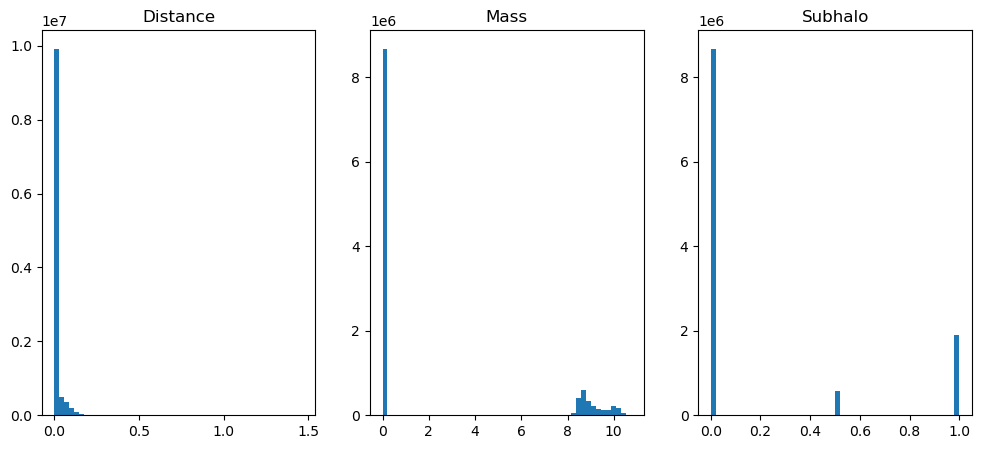

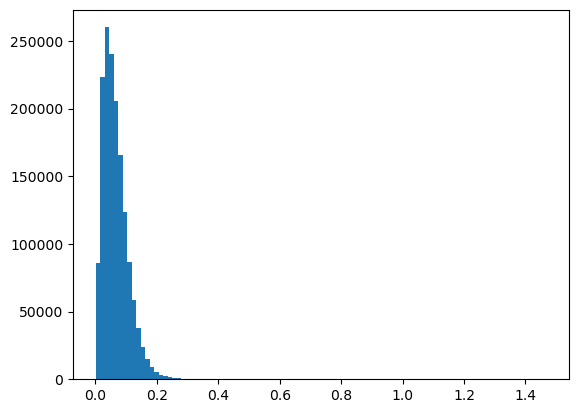

In [23]:
dist = postprocessed_fake[:, 0]
mass = postprocessed_fake[:, 1]
subh = postprocessed_fake[:, 2]

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Display the first image in the first subplot
axs[0].hist(dist.numpy().flatten(), bins = 50)
axs[0].set_title('Distance')

# Display the second image in the second subplot
axs[1].hist(mass.numpy().flatten(), bins = 50)
axs[1].set_title('Mass')

# Display the second image in the second subplot
axs[2].hist(subh.numpy().flatten(), bins = 50)
axs[2].set_title('Subhalo')

plt.show()

nonzero_indices = torch.nonzero(dist.flatten())
nonzero_values = dist.flatten()[nonzero_indices]
plt.hist(nonzero_values.numpy().flatten(), bins = 100)
plt.show()

In [19]:
full_evaluation(postprocessed_fake, dataset)

Analyzing generated merger tree dataset ...

			 CONSISTENCY CHECK


Percentage of consistant images = 97.39%



Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 64.74%
inconsistency due to distance not zero in main branch =  0.00%
inconsistency due to gap between branches =  1.10%
inconsistency due to zgap in branch 63.15%
inconsistency due to last descendant dont exist 1.10%

Number of images with two or more inconsistencies = 296, which is  29.48%
That corresponds to 0.77% of all images


Of all images, 1.69% have zero inconsistency
Of all images, 0.00% have distance main branch inconsistency
Of all images, 0.03% have gap between branches inconsistency
Of all images, 1.65% have gap within branch inconsistency
Of all images, 0.03% have last descendant inconsistency

			 VARIABLE CONSISTENY CHECK of consistent trees
-------------------------------------------------------------------------------------------------------
MASS:
-----------------------------------------

In [24]:
total = check_branch_length(postprocessed_fake, printer = False) 
for i, branch_num in enumerate(total):
    if len(branch_num) > 0:
        lis = torch.stack(branch_num)
        con, incon = check_consistency(lis)
        check_branch_length(con)
        



Percentage of consistant images = 98.64%



Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 40.57%
inconsistency due to distance not zero in main branch =  0.00%
inconsistency due to gap between branches =  2.83%
inconsistency due to zgap in branch 66.98%
inconsistency due to last descendant dont exist 2.83%

Number of images with two or more inconsistencies = 13, which is  12.26%
That corresponds to 0.17% of all images


Of all images, 0.55% have zero inconsistency
Of all images, 0.00% have distance main branch inconsistency
Of all images, 0.04% have gap between branches inconsistency
Of all images, 0.91% have gap within branch inconsistency
Of all images, 0.04% have last descendant inconsistency
number of images with 1 branches is: 0
number of images with 2 branches is: 0
number of images with 3 branches is: 0
number of images with 4 branches is: 0
number of images with 5 branches is: 7677
number of images with 6 branches is: 0
number of images with 7 branches 

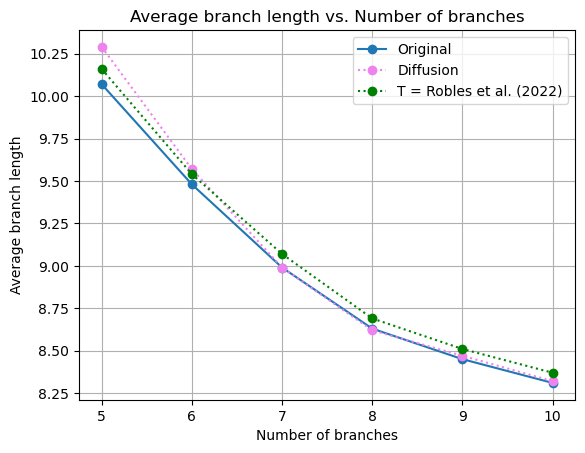

In [29]:
branches = [5, 6, 7, 8, 9, 10]
branch_length = [10.07, 9.48, 8.99, 8.63, 8.45, 8.31]
fake = [10.16, 9.54, 9.07, 8.69, 8.51, 8.37]



# Plot consistency and complexity
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of branches')
ax1.set_ylabel("Average branch length", color="black")
ax1.plot(branches, branch_length, color=color, marker='o', linestyle='-', label='Original')
ax1.tick_params(axis='y', labelcolor="black")



color = 'tab:violet'
ax1.plot(branches, branch_length_T900, color="violet", marker='o', linestyle=':', label='Diffusion')


color = 'tab:green'
ax1.plot(branches, fake, color="green", marker='o', linestyle=':', label='T = Robles et al. (2022)')



# Legend
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(loc='upper right')

# Title
plt.title('Average branch length vs. Number of branches')
plt.savefig("T_branch_results")

# Show plot
plt.grid(True)
plt.show()